# Multi-File Linguistic Analysis
This notebook processes multiple JSON files from a folder and performs linguistic analysis on character memory retellings across different ages.

## Import Required Libraries

In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

## Load All JSON Files from Folder

In [2]:
def load_json_files_from_folder(folder_path):
    """Load all JSON files from a specified folder."""
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    all_data = []
    
    for file_path in json_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                all_data.append(data)
                print(f"Loaded: {os.path.basename(file_path)} - Character: {data.get('character', 'Unknown')}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return all_data

# Load all JSON files from the healthy_data folder
data_folder = "healthy_data"
all_character_data = load_json_files_from_folder(data_folder)
print(f"\nLoaded {len(all_character_data)} character files.")

Loaded: Eva healthy.json - Character: Eva Sanderson (Control Group)
Loaded: Alison healthy.json - Character: Alison Marjorie Bennett (Control Group)
Loaded: Thomas healthy.json - Character: Thomas Delgado (Control Group)
Loaded: Jacob healthy.json - Character: Jacob Stein (Control Group)

Loaded 4 character files.


## Aggregate Retellings Across All Files

In [3]:
def aggregate_retellings_by_age(all_character_data):
    """Combine all retellings from all characters and group by age."""
    aggregated_retellings = defaultdict(list)
    
    for character_data in all_character_data:
        character_name = character_data.get('character', 'Unknown')
        retellings = character_data.get('retellings', [])
        
        for retelling in retellings:
            age = retelling.get('age')
            story = retelling.get('story', '')
            if age is not None and story:
                aggregated_retellings[age].append({
                    'character': character_name,
                    'story': story
                })
    
    return aggregated_retellings

# Aggregate all retellings by age
aggregated_data = aggregate_retellings_by_age(all_character_data)

# Display summary
print("Aggregated retellings by age:")
for age in sorted(aggregated_data.keys()):
    count = len(aggregated_data[age])
    print(f"Age {age}: {count} retellings")
    
# Get all ages for consistent plotting
all_ages = sorted(aggregated_data.keys())

Aggregated retellings by age:
Age 50: 4 retellings
Age 60: 4 retellings
Age 70: 4 retellings
Age 80: 4 retellings
Age 90: 4 retellings


## Plotting Utility Function

In [4]:
def plot_aggregated_metric(metric_dict, label_y: str, title_suffix: str = ""):
    """Plot aggregated metrics by age with trend line."""
    if not metric_dict:
        print(f"No data available for {label_y}")
        return
        
    ages = sorted(metric_dict.keys())
    values = [metric_dict[age] for age in ages]
    
    plt.figure(figsize=(10, 6))
    plt.bar(ages, values, color='skyblue', alpha=0.7)
    
    # Add trend line if we have enough data points
    if len(ages) > 1:
        z = np.polyfit(ages, values, 1)
        p = np.poly1d(z)
        plt.plot(ages, p(ages), "r--", alpha=0.8, linewidth=2, label='Trend')
        plt.legend()
    
    plt.xlabel('Age')
    plt.ylabel(f'{label_y}')
    plt.title(f'{label_y} Across All Characters by Age{title_suffix}')
    plt.xticks(ages)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def calculate_average_metric(aggregated_data, metric_function):
    """Calculate average of a metric across all retellings for each age."""
    age_metrics = {}
    
    for age, retellings in aggregated_data.items():
        metric_values = []
        for retelling in retellings:
            metric_value = metric_function(retelling['story'])
            metric_values.append(metric_value)
        
        if metric_values:
            age_metrics[age] = np.mean(metric_values)
    
    return age_metrics

## Count Nouns by Age

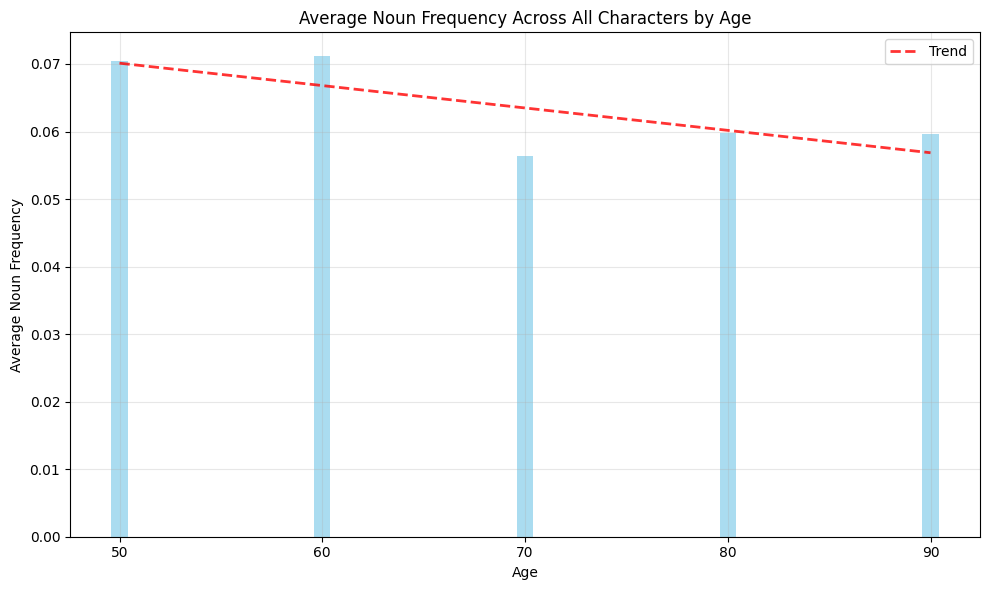

In [5]:
def nouns_freq_in_text(text):
    """Count the number of noun phrases in the given text."""
    blob = TextBlob(text)
    tokens = word_tokenize(text)
    return len(blob.noun_phrases)/ len(tokens)
    

# Calculate average noun frequencies by age
average_noun_freq = calculate_average_metric(aggregated_data, nouns_freq_in_text)
plot_aggregated_metric(average_noun_freq, "Average Noun Frequency")

## Calculate Average Token Length by Age

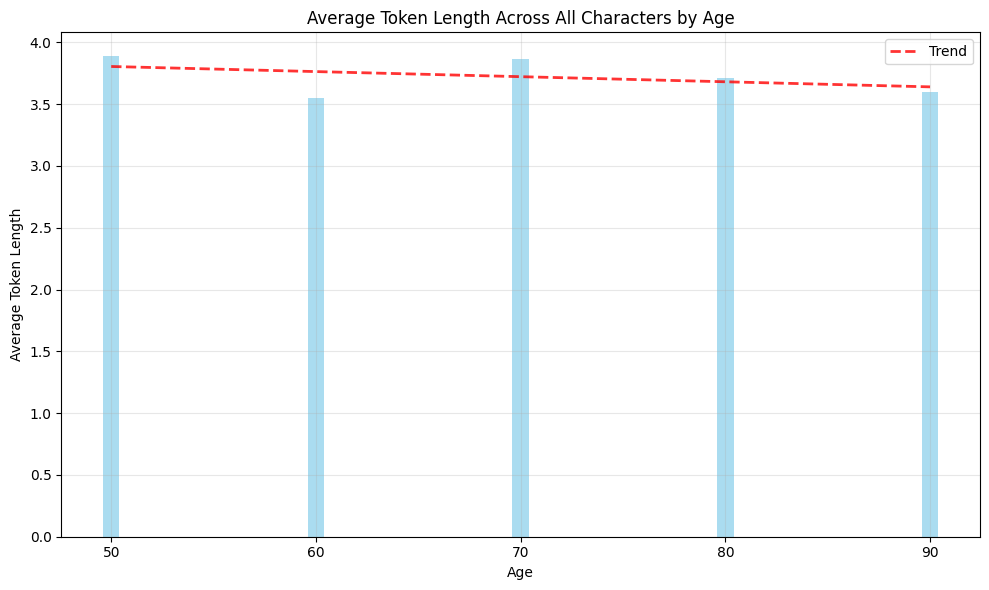

In [6]:
def count_tokens_avg_length_in_text(text):
    """Calculate the average token length in the given text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    return np.mean([len(token) for token in tokens])

# Calculate average token lengths by age
average_token_lengths = calculate_average_metric(aggregated_data, count_tokens_avg_length_in_text)
plot_aggregated_metric(average_token_lengths, "Average Token Length")

## Calculate Stopwords Percentage by Age

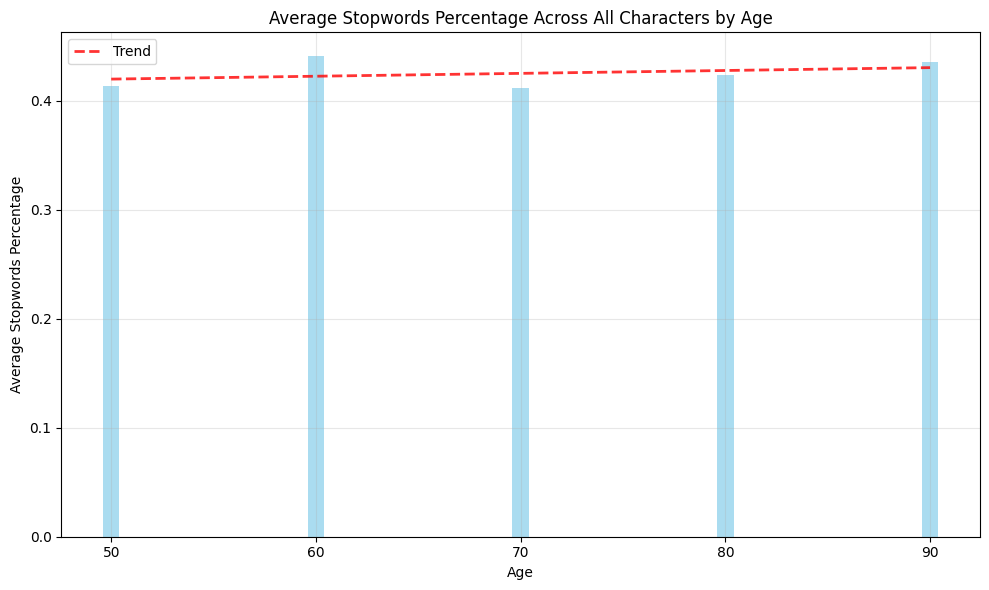

In [7]:
def count_stopwords_percentage_in_text(text):
    """Calculate the percentage of stopwords in the given text."""
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    stopword_count = sum(1 for token in tokens if token.lower() in stop_words)
    return stopword_count / len(tokens)

# Calculate average stopwords percentage by age
average_stopwords_percentage = calculate_average_metric(aggregated_data, count_stopwords_percentage_in_text)
plot_aggregated_metric(average_stopwords_percentage, "Average Stopwords Percentage")

## Calculate Hapax Legomena Frequency by Age

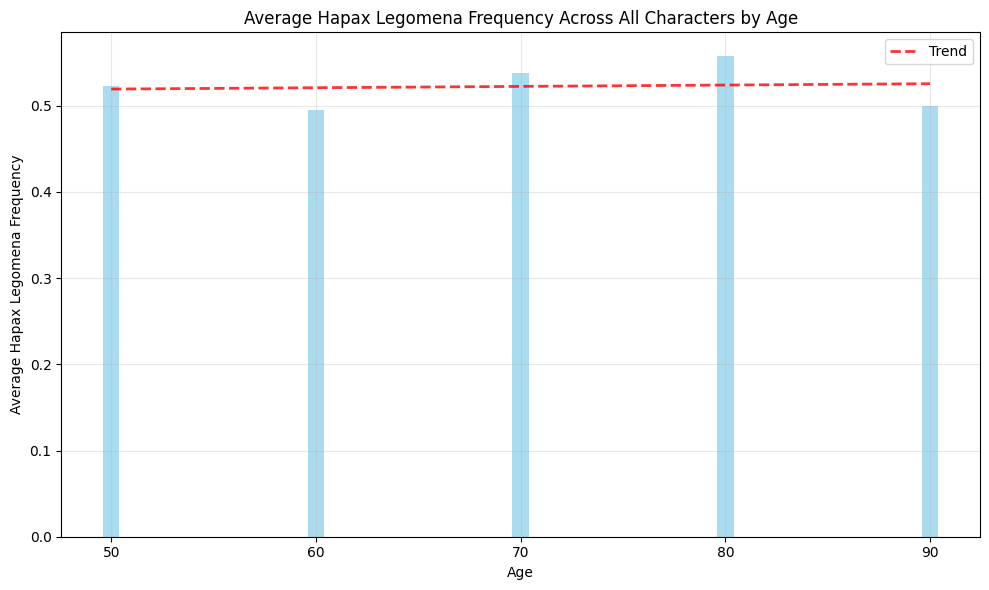

In [8]:
def word_used_once_frequency(text):
    """Calculate the frequency of words used only once in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    once_count = sum(1 for _, count in word_freq.items() if count == 1)
    return once_count / len(tokens)

# Calculate average hapax legomena frequency by age
average_hapax_frequency = calculate_average_metric(aggregated_data, word_used_once_frequency)
plot_aggregated_metric(average_hapax_frequency, "Average Hapax Legomena Frequency")

## Calculate Words Used Once or Twice Frequency by Age

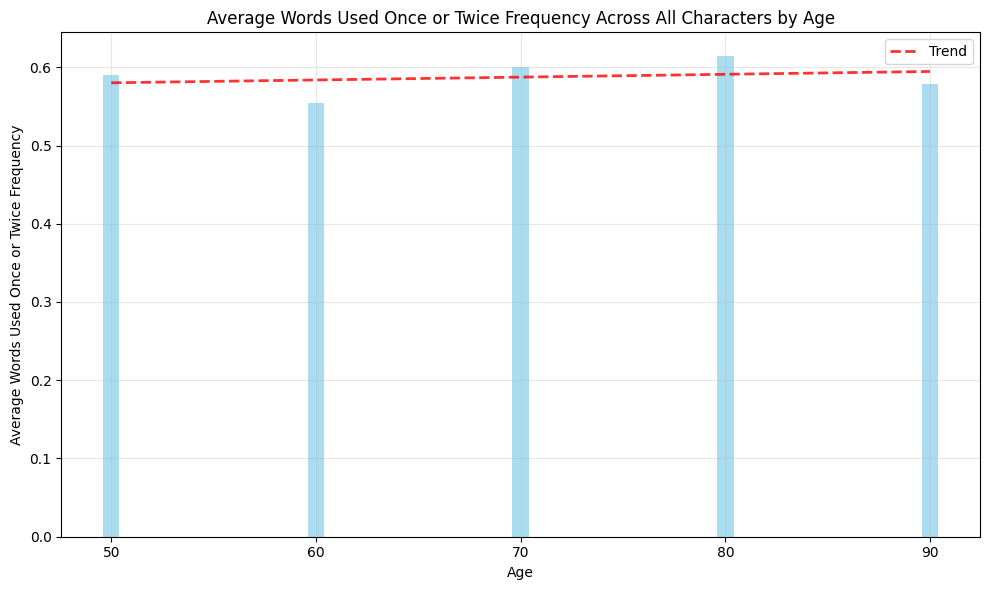

In [9]:
def word_used_once_or_twice_frequency(text):
    """Calculate the frequency of words used once or twice in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    once_or_twice_count = sum(1 for _, count in word_freq.items() if count <= 2)
    return once_or_twice_count / len(tokens)

# Calculate average words used once or twice frequency by age
average_once_or_twice_frequency = calculate_average_metric(aggregated_data, word_used_once_or_twice_frequency)
plot_aggregated_metric(average_once_or_twice_frequency, "Average Words Used Once or Twice Frequency")

## Calculate Brunet Index by Age

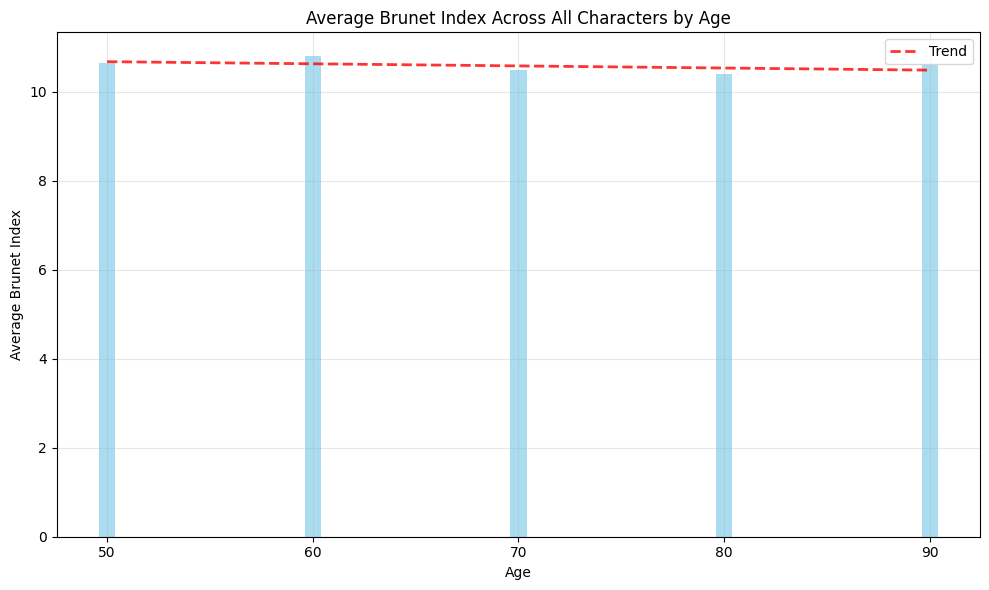

In [10]:
def brunet_index(text, alpha=-0.165):
    """Calculate the Brunet index for the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    unique_words = len(word_freq)
    tokens_count = len(tokens)
    if unique_words == 0 or tokens_count == 0:
        return 0
    return tokens_count ** (unique_words ** alpha)

# Calculate average Brunet index by age
average_brunet_index = calculate_average_metric(aggregated_data, brunet_index)
plot_aggregated_metric(average_brunet_index, "Average Brunet Index")

## Calculate Type-Token Ratio by Age

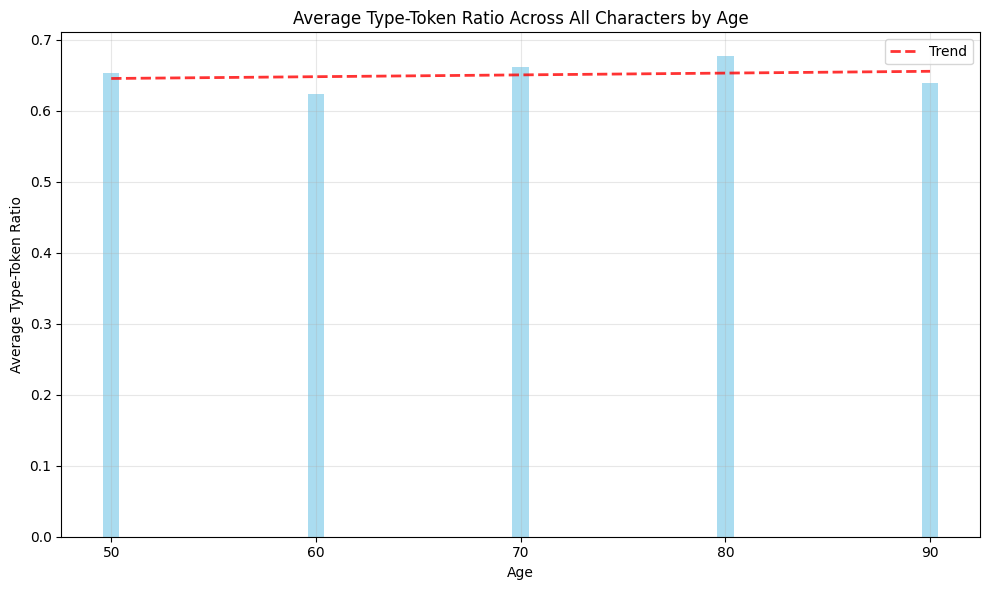

In [11]:
def token_type_ratio(text):
    """Calculate the type-token ratio for the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    unique_words = len(word_freq)
    tokens_count = len(tokens)
    return unique_words / tokens_count if tokens_count > 0 else 0

# Calculate average type-token ratio by age
average_ttr = calculate_average_metric(aggregated_data, token_type_ratio)
plot_aggregated_metric(average_ttr, "Average Type-Token Ratio")

## Calculate Adposition Frequency by Age

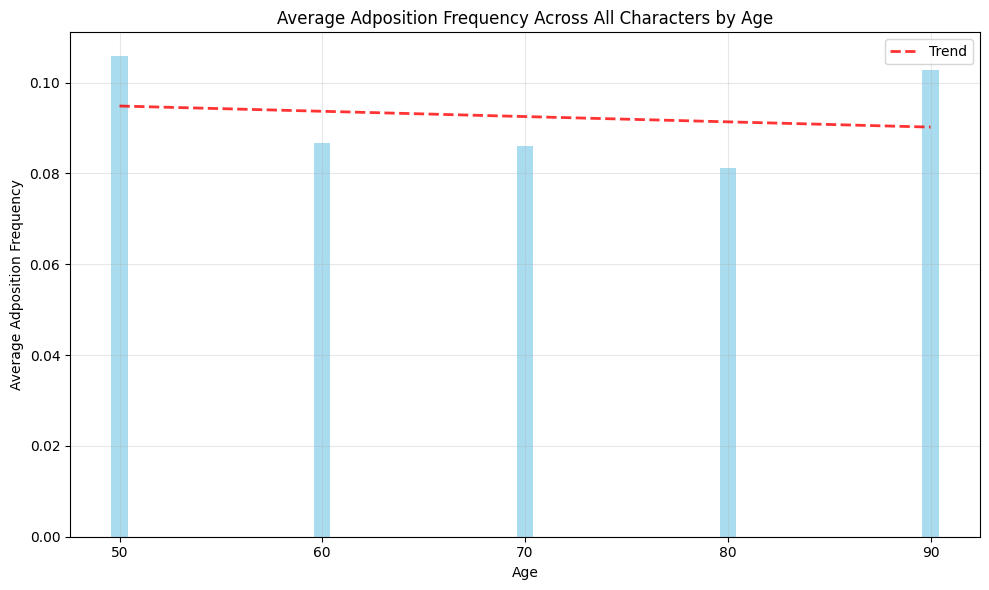

In [12]:
def adposition_frequency(text):
    """Calculate the frequency of adpositions in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    words_and_tags = nltk.pos_tag(tokens)
    adpositions_count = sum(1 for _, tag in words_and_tags if tag == "IN")
    return adpositions_count / len(tokens)

# Calculate average adposition frequency by age
average_adposition_freq = calculate_average_metric(aggregated_data, adposition_frequency)
plot_aggregated_metric(average_adposition_freq, "Average Adposition Frequency")

## Calculate Unigram and Bigram Repetitions by Age

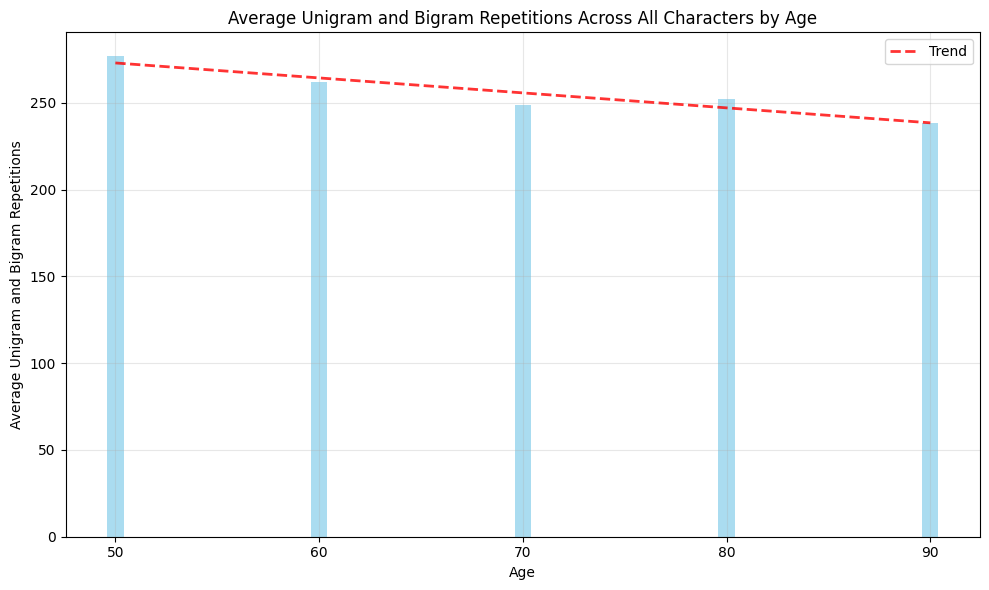

In [13]:
def uni_and_bi_grams_repetitions(text):
    """Calculate the number of unique unigrams and bigrams in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    unigrams = nltk.FreqDist(tokens)
    bigrams = nltk.FreqDist(nltk.bigrams(tokens))
    return len(unigrams) + len(bigrams)

# Calculate average unigram and bigram repetitions by age
average_ngram_repetitions = calculate_average_metric(aggregated_data, uni_and_bi_grams_repetitions)
plot_aggregated_metric(average_ngram_repetitions, "Average Unigram and Bigram Repetitions")

## Load Word Frequency Data (CSV)

In [14]:
def load_csv(file_path):
    """Load a CSV file and return its content."""
    return pd.read_csv(file_path)

# Load word frequency data
try:
    subtl_and_zipf_df = load_csv('subtl_and_zipf.csv')
    # Filter relevant columns
    subtl_and_zipf_df = subtl_and_zipf_df[['Word','FREQcount', 'SUBTLWF', 'Zipf-value']]
    print("Successfully loaded word frequency data.")
    print(f"Shape: {subtl_and_zipf_df.shape}")
    print(subtl_and_zipf_df.head())
except FileNotFoundError:
    print("Warning: subtl_and_zipf.csv not found. Skipping frequency analysis.")
    subtl_and_zipf_df = None

Successfully loaded word frequency data.
Shape: (74286, 4)
    Word  FREQcount   SUBTLWF  Zipf-value
0      a    1041179  20415.27    7.309360
1     aa         87      1.71    3.236317
2    aaa         25      0.49    2.706807
3    aah       2688     52.71    4.721425
4  aahed          1      0.02    1.592864


## Calculate SUBTLEX Frequency by Age

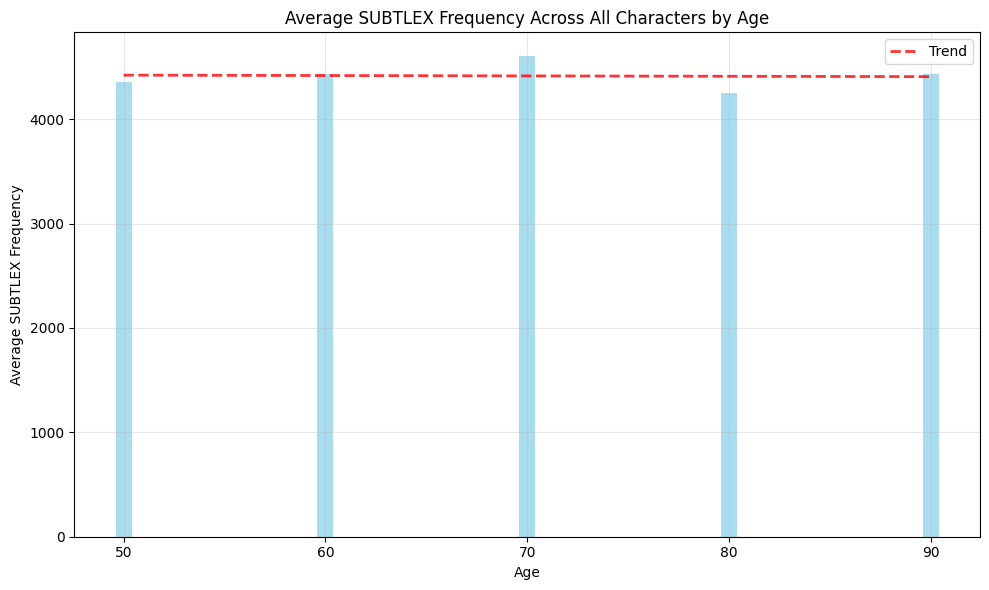

In [15]:
def word_freq_subtl(text, corpus_data):
    """Calculate the frequency of words in the text based on SUBTLEXus data."""
    if corpus_data is None:
        return 0
    
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    
    word_freq = nltk.FreqDist(tokens)
    total_freq = sum(word_freq.values())
    
    subtl_freq = 0
    for word, freq in word_freq.items():
        word_lower = word.lower()
        matching_rows = corpus_data[corpus_data['Word'] == word_lower]
        if not matching_rows.empty:
            subtl_value = matching_rows['SUBTLWF'].values[0]
            subtl_freq += freq * subtl_value
    
    return subtl_freq / total_freq if total_freq > 0 else 0

# Calculate average SUBTLEX frequency by age
if subtl_and_zipf_df is not None:
    def subtl_metric(text):
        return word_freq_subtl(text, subtl_and_zipf_df)
    
    average_subtl_freq = calculate_average_metric(aggregated_data, subtl_metric)
    plot_aggregated_metric(average_subtl_freq, "Average SUBTLEX Frequency")
else:
    print("Skipping SUBTLEX frequency analysis due to missing data.")

## Calculate Zipf Frequency by Age

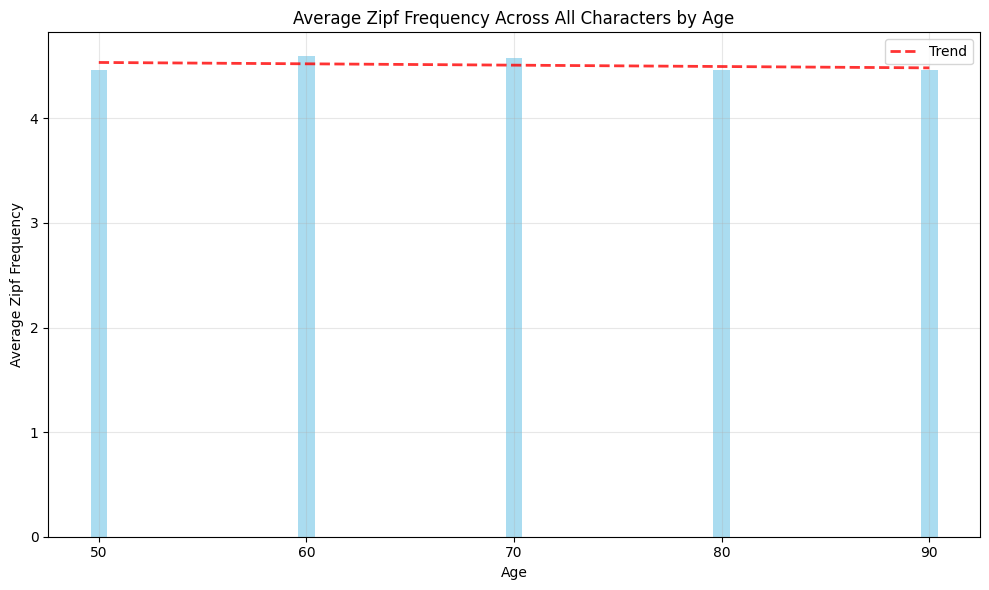

In [16]:
def word_freq_zipf(text, corpus_data):
    """Calculate the frequency of words in the text based on Zipf data."""
    if corpus_data is None:
        return 0
    
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    
    word_freq = nltk.FreqDist(tokens)
    total_freq = sum(word_freq.values())
    
    zipf_freq = 0
    for word, freq in word_freq.items():
        word_lower = word.lower()
        matching_rows = corpus_data[corpus_data['Word'] == word_lower]
        if not matching_rows.empty:
            zipf_value = matching_rows['Zipf-value'].values[0]
            zipf_freq += freq * zipf_value
    
    return zipf_freq / total_freq if total_freq > 0 else 0

# Calculate average Zipf frequency by age
if subtl_and_zipf_df is not None:
    def zipf_metric(text):
        return word_freq_zipf(text, subtl_and_zipf_df)
    
    average_zipf_freq = calculate_average_metric(aggregated_data, zipf_metric)
    plot_aggregated_metric(average_zipf_freq, "Average Zipf Frequency")
else:
    print("Skipping Zipf frequency analysis due to missing data.")

## Summary

This notebook successfully processes multiple JSON files containing character memory retellings and calculates various linguistic features across different ages. The analysis includes:

1. **Noun Phrase Counts** - Measuring semantic density
2. **Token Length** - Average word length analysis
3. **Stopwords Percentage** - Function word usage
4. **Hapax Legomena** - Words used only once
5. **Low-frequency Words** - Words used once or twice
6. **Brunet Index** - Lexical richness measure
7. **Type-Token Ratio** - Vocabulary diversity
8. **Adposition Frequency** - Prepositional usage
9. **N-gram Repetitions** - Unigram and bigram diversity
10. **SUBTLEX & Zipf Frequencies** - Word frequency analysis

The aggregated analysis allows for cross-character comparison and provides insights into linguistic patterns that may correlate with cognitive changes across different age groups.

## Comprehensive Visualization - All Metrics

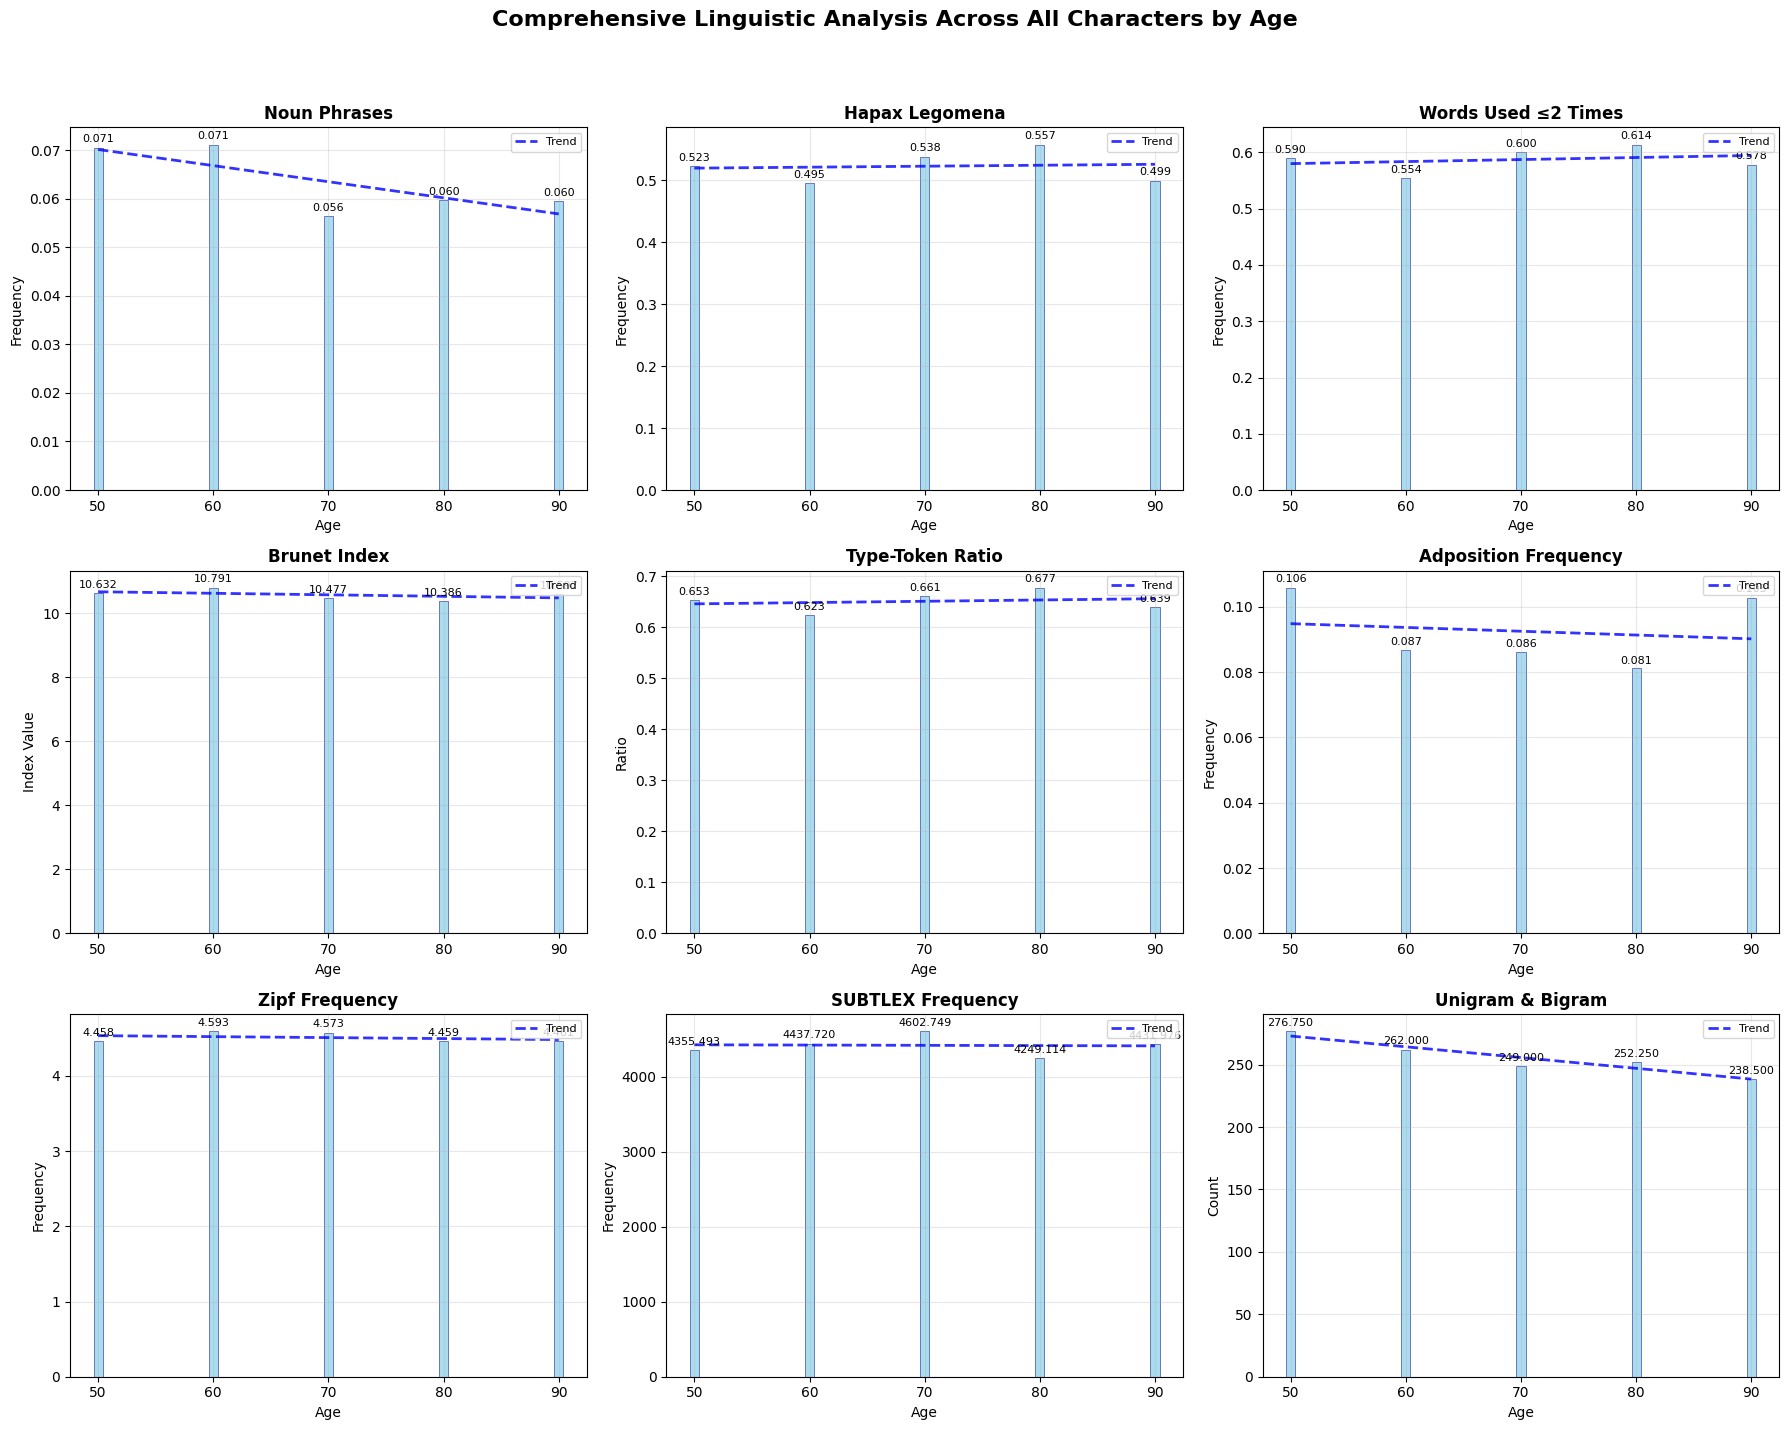

In [18]:
def create_comprehensive_plot():
    """Create a comprehensive 3x3 subplot showing all linguistic metrics."""
    
    # Prepare the data - collect all metrics
    metrics_data = []
    
    # Row 1: Nouns, Words Used Once, Words Used Once or Twice
    metrics_data.append((average_noun_freq, "Noun Phrases", "Frequency"))
    metrics_data.append((average_hapax_frequency, "Hapax Legomena", "Frequency"))
    metrics_data.append((average_once_or_twice_frequency, "Words Used ≤2 Times", "Frequency"))
    
    # Row 2: Brunet Index, TTR, Adposition Frequency
    metrics_data.append((average_brunet_index, "Brunet Index", "Index Value"))
    metrics_data.append((average_ttr, "Type-Token Ratio", "Ratio"))
    metrics_data.append((average_adposition_freq, "Adposition Frequency", "Frequency"))
    
    # Row 3: Zipf, SUBTLEX, Unigram & Bigram
    if subtl_and_zipf_df is not None:
        metrics_data.append((average_zipf_freq, "Zipf Frequency", "Frequency"))
        metrics_data.append((average_subtl_freq, "SUBTLEX Frequency", "Frequency"))
    else:
        # Add empty placeholders if frequency data is not available
        metrics_data.append(({}, "Zipf Frequency", "Frequency"))
        metrics_data.append(({}, "SUBTLEX Frequency", "Frequency"))
    
    metrics_data.append((average_ngram_repetitions, "Unigram & Bigram", "Count"))
    
    # Create the subplot
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Comprehensive Linguistic Analysis Across All Characters by Age', fontsize=16, fontweight='bold')
    
    # Plot each metric
    for i, (metric_dict, title, ylabel) in enumerate(metrics_data):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        if metric_dict:  # Check if we have data
            ages = sorted(metric_dict.keys())
            values = [metric_dict[age] for age in ages]
            
            # Create bar plot
            bars = ax.bar(ages, values, color='skyblue', alpha=0.7, edgecolor='navy', linewidth=0.5)
            
            # Add trend line if we have enough data points
            if len(ages) > 1:
                try:
                    z = np.polyfit(ages, values, 1)
                    p = np.poly1d(z)
                    ax.plot(ages, p(ages), "b--", alpha=0.8, linewidth=2, label='Trend')
                    ax.legend(fontsize=8)
                except:
                    pass  # Skip trend line if calculation fails
            
            # Customize the subplot
            ax.set_xlabel('Age', fontsize=10)
            ax.set_ylabel(ylabel, fontsize=10)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xticks(ages)
            ax.grid(True, alpha=0.3)
            
            # Add value labels on bars for better readability
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=8)
        else:
            # Show message for missing data
            ax.text(0.5, 0.5, 'Data Not Available\n(Missing CSV file)', 
                   ha='center', va='center', transform=ax.transAxes, 
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel('Age', fontsize=10)
            ax.set_ylabel(ylabel, fontsize=10)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Create the comprehensive visualization
create_comprehensive_plot()